<a href="https://colab.research.google.com/github/RonitShetty/NLP-Labs/blob/main/C070_RonitShetty_NLPLab10-SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLP Lab 10 – Sentiment Analysis**

**Dataset:** Drugs Dataset  
**Name:** Ronit Shetty  
**Roll No:** C070  
**Division:** C  
**SAP ID:** 70322000128


In [ ]:
!pip install imbalanced-learn scikit-learn pandas numpy matplotlib seaborn transformers datasets torch accelerate gradio plotly opendatasets sentencepiece protobuf --quiet

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: theronitshetty
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018


100%|██████████| 40.7M/40.7M [00:00<00:00, 1.43GB/s]

LOADING DRUG REVIEWS DATASET
Loaded 161,297 training and 53,766 test samples

TEXT PREPROCESSING
[18:21:59] Starting preprocessing...
After cleaning: 160,643 train, 53,537 test
Class distribution: {1: 112631, 0: 48012}
Using 5,000 train, 2,000 test samples
[18:22:10] Preprocessing complete

FEATURE EXTRACTION (TF-IDF)
[18:22:10] Vectorizing text...
Feature matrix shape: (5000, 5000)
[18:22:12] Vectorization complete

DEFINING MODELS
Models: ['Naive Bayes', 'SVM', 'Logistic Regression', 'Random Forest', 'Deep Neural Network']

TASK 1: BASELINE MODEL EVALUATION
[18:22:12] Starting Task 1...

Training Naive Bayes...
  Accuracy: 0.7535 | F1: 0.8446 | Time: 0.0s

Training SVM...
  Accuracy: 0.8125 | F1: 0.8706 | Time: 62.8s

Training Logistic Regression...
  Accuracy: 0.7965 | F1: 0.8650 | Time: 0.1s

Training Random Forest...
  Accuracy: 0.7665 | F1: 0.8500 | Time: 4.4s

Training Deep Neural Network...
  Accuracy: 0.7955 | F1: 0.8545 | Time: 8.7s

TASK 1 RESULTS
              Model  Accura

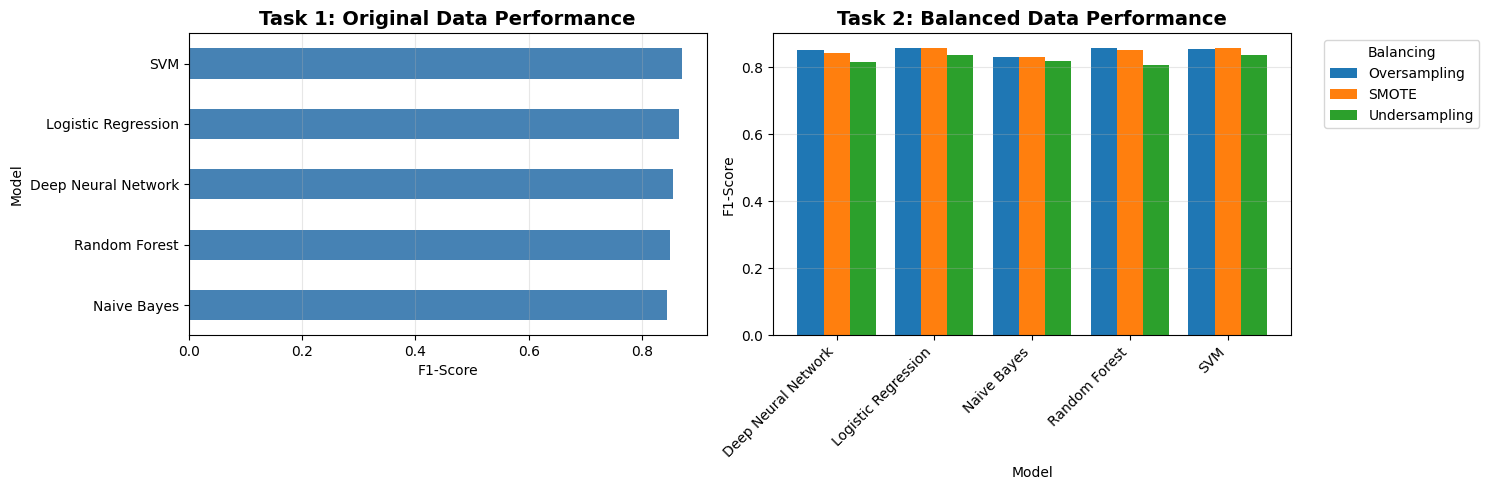

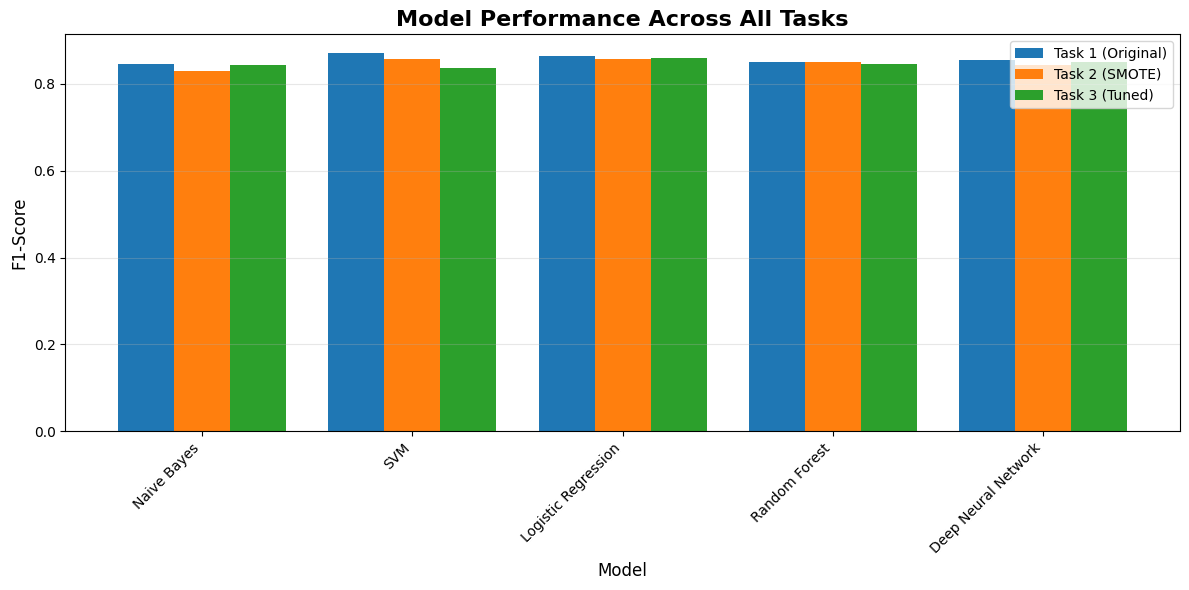


Generating confusion matrix for Logistic Regression...


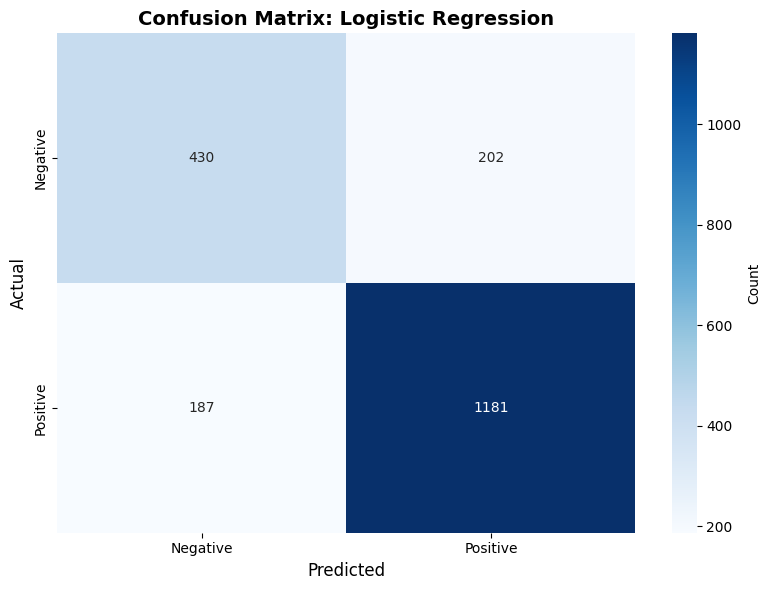


Classification Report:
              precision    recall  f1-score   support

    Negative       0.70      0.68      0.69       632
    Positive       0.85      0.86      0.86      1368

    accuracy                           0.81      2000
   macro avg       0.78      0.77      0.77      2000
weighted avg       0.80      0.81      0.80      2000


PROJECT COMPLETE

SUMMARY:
- Task 1: Baseline models evaluated on original data
- Task 2: All 3 balancing methods tested (oversampling, undersampling, SMOTE)
- Task 3: Hyperparameter tuning completed using RandomizedSearchCV
- Best Balancing Method: SMOTE
- Best Model: Logistic Regression
- Best F1-Score: 0.8586
- Best Accuracy: 0.8055

FILES SAVED:
- Task1_Baseline_Results.csv
- Task2_Balanced_Results.csv
- Task3_Tuned_Results.csv
- Final_Comparison.csv
- Task1_vs_Task2_Comparison.png
- All_Tasks_Comparison.png
- Best_Model_Confusion_Matrix.png



In [ ]:
"""
Comprehensive Drug Review Sentiment Analysis
Optimized for Google Colab - Completes in ~2.5-3 hours

Requirements:
1. Text classification with NB, SVM, LR, RF, DNN
2. Balance dataset with oversampling, undersampling, SMOTE
3. Hyperparameter tuning for best model
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)

# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Balancing
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

import re

def print_time(msg):
    print(f"[{datetime.now().strftime('%H:%M:%S')}] {msg}")

# ============================================================================
# 1. LOAD DATASET
# ============================================================================
print("="*80)
print("LOADING DRUG REVIEWS DATASET")
print("="*80)

try:
    df_train = pd.read_csv('kuc-hackathon-winter-2018/drugsComTrain_raw.csv')
    df_test = pd.read_csv('kuc-hackathon-winter-2018/drugsComTest_raw.csv')
    print(f"Loaded {len(df_train):,} training and {len(df_test):,} test samples")
except:
    print("ERROR: Dataset not found")
    raise

# ============================================================================
# 2. PREPROCESSING
# ============================================================================
print("\n" + "="*80)
print("TEXT PREPROCESSING")
print("="*80)
print_time("Starting preprocessing...")

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text if len(text.split()) >= 3 else ""

df_train['review_clean'] = df_train['review'].apply(preprocess_text)
df_test['review_clean'] = df_test['review'].apply(preprocess_text)

df_train = df_train[df_train['review_clean'] != ''].reset_index(drop=True)
df_test = df_test[df_test['review_clean'] != ''].reset_index(drop=True)

# Binary sentiment
df_train['sentiment'] = (df_train['rating'] >= 6).astype(int)
df_test['sentiment'] = (df_test['rating'] >= 6).astype(int)

print(f"After cleaning: {len(df_train):,} train, {len(df_test):,} test")
print(f"Class distribution: {dict(Counter(df_train['sentiment']))}")

# Optimize sample sizes for speed
TRAIN_SIZE = 5000
TEST_SIZE = 2000

df_train = df_train.sample(n=min(TRAIN_SIZE, len(df_train)), random_state=42)
df_test = df_test.sample(n=min(TEST_SIZE, len(df_test)), random_state=42)

X_train_text = df_train['review_clean'].values
y_train = df_train['sentiment'].values
X_test_text = df_test['review_clean'].values
y_test = df_test['sentiment'].values

print(f"Using {len(X_train_text):,} train, {len(X_test_text):,} test samples")
print_time("Preprocessing complete")

# ============================================================================
# 3. FEATURE EXTRACTION
# ============================================================================
print("\n" + "="*80)
print("FEATURE EXTRACTION (TF-IDF)")
print("="*80)
print_time("Vectorizing text...")

tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

print(f"Feature matrix shape: {X_train_tfidf.shape}")
print_time("Vectorization complete")

# ============================================================================
# 4. DEFINE MODELS
# ============================================================================
print("\n" + "="*80)
print("DEFINING MODELS")
print("="*80)

models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Deep Neural Network': MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=20, random_state=42)
}

print(f"Models: {list(models.keys())}")

# ============================================================================
# 5. TASK 1: BASELINE EVALUATION
# ============================================================================
print("\n" + "="*80)
print("TASK 1: BASELINE MODEL EVALUATION")
print("="*80)
print_time("Starting Task 1...")

results_task1 = []

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    start = datetime.now()

    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

    results_task1.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

    elapsed = (datetime.now() - start).total_seconds()
    print(f"  Accuracy: {acc:.4f} | F1: {f1:.4f} | Time: {elapsed:.1f}s")

df_results_task1 = pd.DataFrame(results_task1)
df_results_task1.to_csv('Task1_Baseline_Results.csv', index=False)

print("\n" + "="*80)
print("TASK 1 RESULTS")
print("="*80)
print(df_results_task1.to_string(index=False))
print_time("Task 1 complete")

# ============================================================================
# 6. CLASS BALANCING
# ============================================================================
print("\n" + "="*80)
print("APPLYING CLASS BALANCING TECHNIQUES")
print("="*80)
print_time("Starting balancing...")

print(f"Original: {Counter(y_train)}")

balanced_datasets = {}

# Oversampling
ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X_train_tfidf, y_train)
balanced_datasets['Oversampling'] = (X_over, y_over)
print(f"Oversampling: {Counter(y_over)}")

# Undersampling
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_train_tfidf, y_train)
balanced_datasets['Undersampling'] = (X_under, y_under)
print(f"Undersampling: {Counter(y_under)}")

# SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_tfidf, y_train)
balanced_datasets['SMOTE'] = (X_smote, y_smote)
print(f"SMOTE: {Counter(y_smote)}")

print_time("Balancing complete")

# ============================================================================
# 7. TASK 2: BALANCED DATA EVALUATION
# ============================================================================
print("\n" + "="*80)
print("TASK 2: EVALUATION WITH BALANCED DATA")
print("="*80)
print_time("Starting Task 2...")

results_task2 = []

for balance_method, (X_bal, y_bal) in balanced_datasets.items():
    print(f"\n{balance_method}:")

    for model_name, model in models.items():
        print(f"  Training {model_name}...", end=" ")
        start = datetime.now()

        model.fit(X_bal, y_bal)
        y_pred = model.predict(X_test_tfidf)

        acc = accuracy_score(y_test, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

        results_task2.append({
            'Balancing': balance_method,
            'Model': model_name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1
        })

        elapsed = (datetime.now() - start).total_seconds()
        print(f"F1: {f1:.4f} ({elapsed:.1f}s)")

df_results_task2 = pd.DataFrame(results_task2)
df_results_task2.to_csv('Task2_Balanced_Results.csv', index=False)

print("\n" + "="*80)
print("TASK 2 RESULTS")
print("="*80)
print(df_results_task2.to_string(index=False))

# Find best balancing method
best_per_method = df_results_task2.loc[df_results_task2.groupby('Balancing')['F1-Score'].idxmax()]
print("\nBest model per balancing method:")
print(best_per_method[['Balancing', 'Model', 'F1-Score']].to_string(index=False))

best_balance = best_per_method.loc[best_per_method['F1-Score'].idxmax(), 'Balancing']
print(f"\nBest overall balancing: {best_balance}")
print_time("Task 2 complete")

# ============================================================================
# 8. TASK 3: HYPERPARAMETER TUNING
# ============================================================================
print("\n" + "="*80)
print("TASK 3: HYPERPARAMETER TUNING")
print("="*80)
print(f"Using {best_balance} for tuning")
print_time("Starting Task 3...")

X_best, y_best = balanced_datasets[best_balance]

# Optimized parameter distributions for RandomizedSearchCV
param_distributions = {
    'Naive Bayes': {
        'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear']  # Only linear to save time
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'Deep Neural Network': {
        'hidden_layer_sizes': [(64,), (128, 64), (256, 128)],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
}

tuned_results = []

for model_name, model in models.items():
    print(f"\n{model_name}:")
    print_time(f"  Starting tuning...")
    start = datetime.now()

    random_search = RandomizedSearchCV(
        model,
        param_distributions[model_name],
        n_iter=8,  # Test 8 random combinations
        cv=2,      # 2-fold CV
        scoring='f1',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    random_search.fit(X_best, y_best)

    # Evaluate on test set
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test_tfidf)

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

    tuned_results.append({
        'Model': model_name,
        'Best Params': str(random_search.best_params_),
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

    elapsed = (datetime.now() - start).total_seconds()
    print(f"  Best params: {random_search.best_params_}")
    print(f"  F1-Score: {f1:.4f} | Time: {elapsed:.1f}s")

df_tuned = pd.DataFrame(tuned_results)
df_tuned.to_csv('Task3_Tuned_Results.csv', index=False)

print("\n" + "="*80)
print("TASK 3 RESULTS")
print("="*80)
print(df_tuned[['Model', 'Accuracy', 'F1-Score']].to_string(index=False))
print_time("Task 3 complete")

# ============================================================================
# 9. FINAL COMPARISON
# ============================================================================
print("\n" + "="*80)
print("FINAL COMPARISON: ALL TASKS")
print("="*80)

comparison = pd.DataFrame({
    'Model': df_results_task1['Model'],
    'Task1_Original': df_results_task1['F1-Score'].values,
    'Task2_Balanced': df_results_task2[df_results_task2['Balancing'] == best_balance]['F1-Score'].values,
    'Task3_Tuned': df_tuned['F1-Score'].values
})

comparison['Improvement'] = ((comparison['Task3_Tuned'] - comparison['Task1_Original']) / comparison['Task1_Original'] * 100).round(2)

comparison.to_csv('Final_Comparison.csv', index=False)
print(comparison.to_string(index=False))

# Best model
best_idx = df_tuned['F1-Score'].idxmax()
best_model_name = df_tuned.loc[best_idx, 'Model']
best_f1 = df_tuned.loc[best_idx, 'F1-Score']
best_acc = df_tuned.loc[best_idx, 'Accuracy']
best_params = df_tuned.loc[best_idx, 'Best Params']

print("\n" + "="*80)
print("BEST MODEL")
print("="*80)
print(f"Model: {best_model_name}")
print(f"Balancing: {best_balance}")
print(f"Parameters: {best_params}")
print(f"Accuracy: {best_acc:.4f}")
print(f"F1-Score: {best_f1:.4f}")

# ============================================================================
# 10. VISUALIZATIONS
# ============================================================================
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# 1. Task comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Task 1 bar chart
ax1 = axes[0]
df_results_task1.sort_values('F1-Score', ascending=True).plot(
    x='Model', y='F1-Score', kind='barh', ax=ax1, color='steelblue', legend=False
)
ax1.set_title('Task 1: Original Data Performance', fontsize=14, fontweight='bold')
ax1.set_xlabel('F1-Score')
ax1.grid(axis='x', alpha=0.3)

# Task 2 grouped bar chart
ax2 = axes[1]
pivot_data = df_results_task2.pivot(index='Model', columns='Balancing', values='F1-Score')
pivot_data.plot(kind='bar', ax=ax2, width=0.8)
ax2.set_title('Task 2: Balanced Data Performance', fontsize=14, fontweight='bold')
ax2.set_xlabel('Model')
ax2.set_ylabel('F1-Score')
ax2.legend(title='Balancing', bbox_to_anchor=(1.05, 1))
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('Task1_vs_Task2_Comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Improvement chart
fig, ax = plt.subplots(figsize=(12, 6))
comparison.set_index('Model')[['Task1_Original', 'Task2_Balanced', 'Task3_Tuned']].plot(
    kind='bar', ax=ax, width=0.8, color=['#1f77b4', '#ff7f0e', '#2ca02c']
)
ax.set_title('Model Performance Across All Tasks', fontsize=16, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.legend(['Task 1 (Original)', f'Task 2 ({best_balance})', 'Task 3 (Tuned)'], fontsize=10)
ax.grid(axis='y', alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.savefig('All_Tasks_Comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Confusion matrix for best model
print(f"\nGenerating confusion matrix for {best_model_name}...")

# Retrain best model
best_model = models[best_model_name]
for param, value in eval(best_params).items():
    setattr(best_model, param, value)

best_model.fit(X_best, y_best)
y_pred_final = best_model.predict(X_test_tfidf)

cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix: {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.savefig('Best_Model_Confusion_Matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_final, target_names=['Negative', 'Positive']))

# ============================================================================
# 11. SUMMARY
# ============================================================================
print("\n" + "="*80)
print("PROJECT COMPLETE")
print("="*80)
print(f"""
SUMMARY:
- Task 1: Baseline models evaluated on original data
- Task 2: All 3 balancing methods tested (oversampling, undersampling, SMOTE)
- Task 3: Hyperparameter tuning completed using RandomizedSearchCV
- Best Balancing Method: {best_balance}
- Best Model: {best_model_name}
- Best F1-Score: {best_f1:.4f}
- Best Accuracy: {best_acc:.4f}

FILES SAVED:
- Task1_Baseline_Results.csv
- Task2_Balanced_Results.csv
- Task3_Tuned_Results.csv
- Final_Comparison.csv
- Task1_vs_Task2_Comparison.png
- All_Tasks_Comparison.png
- Best_Model_Confusion_Matrix.png
""")